# A notebook to demonstrate clustering analysis on count variances

Here can be found the results of k-means clustering acting on the variance of counts of different genomic features across different epigenomic environments.

In [191]:
import pybiomart
import os
import pickle
import pandas as pd
import seaborn as sns
import pybedtools
import pybedtools.featurefuncs as featurefuncs
import umap
import numpy as np
from sklearn.preprocessing import maxabs_scale 

In [192]:
activity_var_df = pd.read_pickle("data/activity_variances.pkl")
ctcf_var_df = pd.read_pickle("data/iap_variances.pkl")
tissue_var_df = pd.read_pickle("data/activity_tissue_variances.pkl")
# distances_df = pd.read_pickle("data/iap_distances.pkl")
concat_list = [activity_var_df.sort_index(),
               ctcf_var_df.iloc[:, 7:].sort_index(),
               tissue_var_df.iloc[:, 7:].sort_index()]
total_df = pd.concat(concat_list, axis=1)
# total_df = pd.concat([total_df, distances_df.iloc[:, 7:].sort_index()], axis=1)
total_df

,chrom,start,end,element_id,length,strand,val_result,Enhancer_heart_ACTIVE_variance,Enhancer_heart_ACTIVE_mean,Promoter_heart_ACTIVE_variance,...,Promoter_POISED_tissuevariance,Promoter_POISED_tissuemean,Promoter_Flanking_Region_POISED_tissuevariance,Promoter_Flanking_Region_POISED_tissuemean,Enhancer_REPRESSED_tissuevariance,Enhancer_REPRESSED_tissuemean,Promoter_REPRESSED_tissuevariance,Promoter_REPRESSED_tissuemean,Promoter_Flanking_Region_REPRESSED_tissuevariance,Promoter_Flanking_Region_REPRESSED_tissuemean
28,chr1,3031358,3031710,28,353,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0
182,chr1,3143092,3148151,182,5060,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.09,0.1
1272,chr1,3997836,3998160,1272,325,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1427,chr1,4132179,4132516,1427,338,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1976,chr1,4556987,4559597,1976,2611,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.09,0.1,0.0,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245666,chr9,123742716,123749810,4245666,7095,-,Tissue-specific,0.0,0.0,0.0,...,0.24,0.6,0.00,0.0,0.0,0.0,0.09,0.1,0.00,0.0
4245722,chr9,123783363,123788707,4245722,5345,+,-1,0.0,0.0,0.0,...,0.24,0.6,0.00,0.0,0.0,0.0,0.09,0.1,0.00,0.0
4246111,chr9,124080169,124082990,4246111,2822,+,Tissue-specific,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0
4246418,chr9,124376688,124378655,4246418,1968,-,-1,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0


In [195]:
total_df["integer_encodings"] = total_df["val_result"].copy()
total_df["val_result"] = total_df["val_result"].replace("-1", "Untested")

total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Untested", -1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("True ME", 1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("False-positive", 2)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Tissue-specific", 3)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace(3, 1)
cols = []
cols = total_df.columns.tolist()
cols = cols[:7] + [cols[-1]] + cols[7:-1]
total_df = total_df.loc[:, cols]
print(total_df.shape)

# Generating validation dataframe for model training:
val_df = total_df[total_df.val_result != "Untested"].copy()
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)

(8059, 50)


In [194]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MaxAbsScaler, scale

# Selecting high variance features:
selector = VarianceThreshold(threshold=0.005)
selector.fit(total_df.iloc[:, 8:])
support = selector.get_support(indices=True)

# Extracting high variance features:
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]
print(kbest_total.shape)
kbest_val = val_df.iloc[:, 8:][val_df.iloc[:, 8:].columns[support]]

# Normalising variances & counts:
transformer = MaxAbsScaler().fit(kbest_total)
kbest_total_abs = transformer.transform(kbest_total)
kbest_val_abs = transformer.transform(kbest_val)

(8059, 22)


In [181]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(kbest_total_abs)
embedding_total = pca.transform(kbest_total_abs)
# embedding_val = pca.transform(kbest_val_abs)

In [182]:
import matplotlib.pyplot as plt
import matplotlib
hue_order = ["Untested", "Tissue-specific", "True ME", "False-positive"]

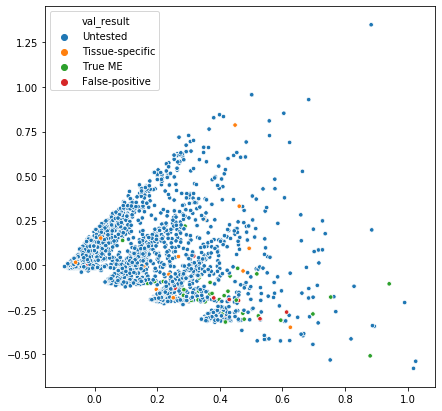

In [183]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

ax = sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1],
                     hue=total_df["val_result"], hue_order=hue_order, s=20, marker='o')
# ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
plt.savefig("plots/pca_total.png", dpi=200)
plt.savefig("plots/pca_total.pdf")

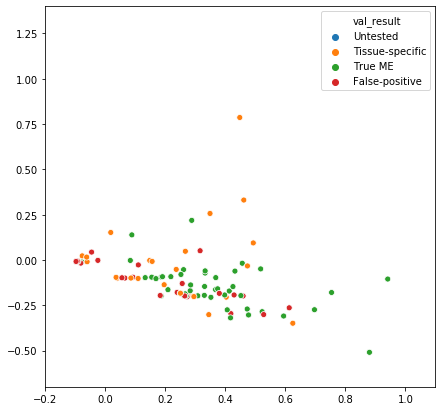

In [184]:
matplotlib.rcParams['figure.figsize'] = [7, 7]
val_df.loc[:, "pca_x"] = embedding_val[:, 0]
val_df.loc[:, "pca_y"] = embedding_val[:, 1]

ax = sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["val_result"], hue_order=hue_order)
ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
plt.savefig("plots/pca_val.png", dpi=200)
plt.savefig("plots/pca_val.pdf")

In [185]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(kbest_total_abs)
total_category_labels = pd.Series(kmeans.labels_)
total_category_labels.index = total_df["element_id"].astype(int).to_list()

sorted_total_df = total_df.iloc[:, 0:7].copy(deep=True)
sorted_total_df["cluster_assignments"] = total_category_labels

hue_order = ["A", "B", "C", "D", "E"]

In [186]:
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(0, "A")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(1, "B")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(2, "C")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(3, "D")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(4, "E")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(5, "F")
sorted_total_df["cluster_assignments"].value_counts().sort_index()

A     638
B    5519
C     254
D    1182
E     466
Name: cluster_assignments, dtype: int64

In [187]:
sorted_total_df.groupby(['cluster_assignments'])["val_result"].value_counts()

cluster_assignments  val_result     
A                    Untested            610
                     True ME              16
                     False-positive        7
                     Tissue-specific       5
B                    Untested           5504
                     False-positive        9
                     Tissue-specific       4
                     True ME               2
C                    Untested            214
                     True ME              28
                     False-positive        6
                     Tissue-specific       6
D                    Untested           1171
                     Tissue-specific       7
                     False-positive        4
E                    Untested            463
                     Tissue-specific       2
                     True ME               1
Name: val_result, dtype: int64

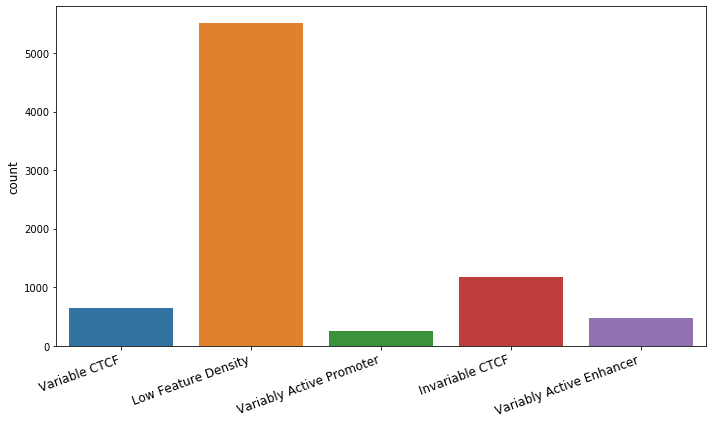

In [188]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
ax = sns.countplot(x="cluster_assignments", data=sorted_total_df, order=hue_order)
ax.set(xticklabels=["Variable CTCF", "Low Feature Density",
                    "Variably Active Promoter", "Invariable CTCF",
                    "Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
plt.tight_layout()

plt.savefig("plots/kcluster_countplot.png", dpi=200)
plt.savefig("plots/kcluster_countplot.pdf")

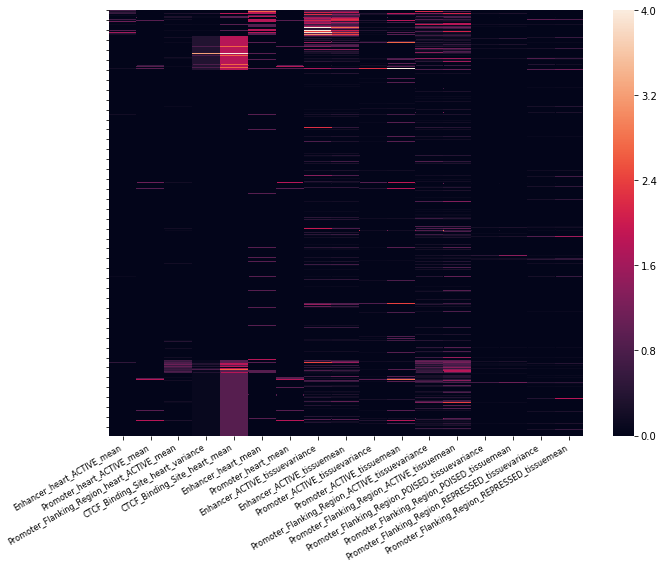

In [179]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

kbest_total["cluster_assignments"] = sorted_total_df["cluster_assignments"]
kbest_total = kbest_total.sort_values(by=["cluster_assignments"])
ax = sns.heatmap(kbest_total.iloc[:, :-1], vmin=0, vmax=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8, horizontalalignment='right')
ax.set_yticklabels([])
plt.tight_layout()
plt.savefig("plots/kcluster_heatmap.png", dpi=200)
plt.savefig("plots/kcluster_heatmap.pdf")

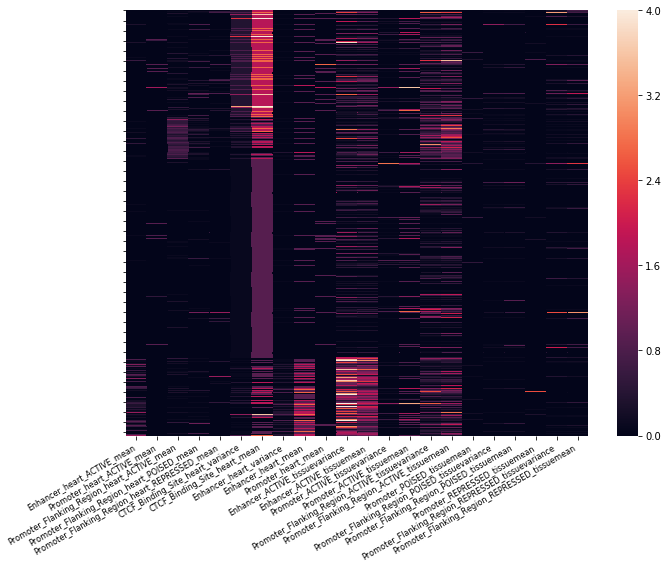

In [92]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

kbest_interest = kbest_total[kbest_total["cluster_assignments"] != "B"]
ax = sns.heatmap(kbest_interest.iloc[:, :-1], vmin=0, vmax=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8, horizontalalignment='right')
ax.set_yticklabels([])
plt.tight_layout()
plt.savefig("plots/kcluster_heatmap_interest.png", dpi=200)
plt.savefig("plots/kcluster_heatmap_interest.pdf")

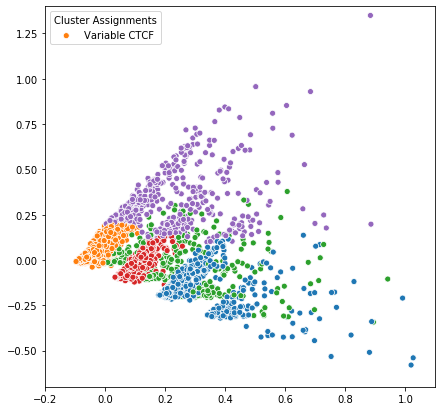

In [45]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

ax = sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1],
                     hue=sorted_total_df["cluster_assignments"], hue_order=hue_order, legend=False)
ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
new_labels = ["Variable CTCF", "Low Feature Density",
              "Variably Active Promoter", "Invariable CTCF",
              "Variably Active Enhancer"]
plt.legend(title='Cluster Assignments', loc='upper left', labels=new_labels)

plt.savefig("plots/pca_kcluster.png", dpi=200)
plt.savefig("plots/pca_kcluster.pdf")

In [46]:
pyroval_bed = pybedtools.BedTool("data/IAP_validation.July2019.stranded.with_IDs.bed")
names = ["chrom", "start", "end", "strand", "gene",
         "blueprint", "ear", "b_cell", "val_status", "element_id"]
pyroval_df = pyroval_bed.to_dataframe(names=names)
pyroval_df = pyroval_df[pyroval_df["ear"].notnull()]
pyroval_df = pyroval_df[pyroval_df["element_id"] != "."]
pyroval_df = pyroval_df[pyroval_df["chrom"] != "chrX"]

pyroval_df.index = pyroval_df["element_id"].astype(int).to_list()
pyroval_df

,chrom,start,end,strand,gene,blueprint,ear,b_cell,val_status,element_id
353879,chr10,18139121,18139597,+,Ect2l,28.479482,12.356460,NaN,True ME,353879
363443,chr10,23726341,23726813,+,Rps12,52.083333,12.379583,NaN,True ME,363443
420013,chr10,59381799,59387060,+,P4ha1,29.895833,12.489792,NaN,True ME,420013
457485,chr10,78020226,78025621,+,Aire,30.208333,12.930833,NaN,True ME,457485
499010,chr10,99599559,99600037,+,Gm20110,29.166667,19.832917,NaN,True ME,499010
...,...,...,...,...,...,...,...,...,...,...
3906187,chr8,72024783,72033082,-,Cyp4f18,41.020833,4.624444,7.175556,False-positive,3906187
3906764,chr8,72228229,72232950,-,Fam32a,30.104167,0.551666,5.849000,False-positive,3906764
4200422,chr9,103108602,103109112,+,Rab6b,37.500000,44.126670,NaN,True ME,4200422
4245666,chr9,123742717,123749810,-,Ccr9,36.875000,1.207500,12.340000,Tissue-specific,4245666


In [47]:
sorted_total_df["ear"] = pyroval_df["ear"]
blueprint_categories = sorted_total_df[sorted_total_df.ear.notnull()]
blueprint_categories["cluster_assignments"].value_counts(sort=False).sort_index()

A    27
B    14
C    40
D     9
E     3
Name: cluster_assignments, dtype: int64

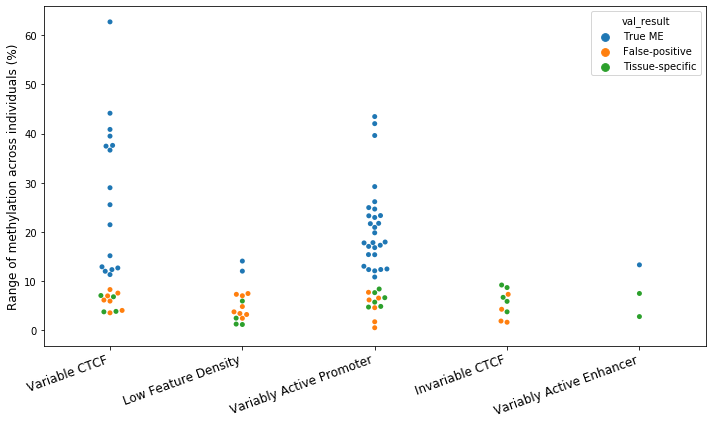

In [71]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
ax = sns.swarmplot(x="cluster_assignments", y="ear", hue="val_result", order=hue_order, data=blueprint_categories)
ax.set(xticklabels=["Variable CTCF", "Low Feature Density",
                    "Variably Active Promoter", "Invariable CTCF",
                    "Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)
plt.tight_layout()

plt.savefig("plots/validation_swarmplot.png", dpi=200)
plt.savefig("plots/validation_swarmplot.pdf")

In [49]:
import scipy.stats as stats
stats.ttest_ind(blueprint_categories['ear'][blueprint_categories['cluster_assignments'] == 'A'],
                blueprint_categories['ear'][blueprint_categories['cluster_assignments'] == 'B'],
                nan_policy='omit')

Ttest_indResult(statistic=3.0957629983235564, pvalue=0.0036259721637040333)

In [50]:
methylation_df = pd.read_csv("data/IAP_LTR.blueprint_methy_ranges.tsv", sep='\t', header=0)
methylation_df = methylation_df.loc[methylation_df["edge"] == "5'", :]
methylation_df.index = methylation_df["element.ID"].astype(int).to_list()
methylation_df

,element.ID,side,B.range1,B.range2,T.range1,T.range2,mean1,mean2,strand,edge
28,28,right,0.089552,0.052910,0.040000,0.021970,0.064776,0.037440,-,5'
182,182,right,0.064516,0.044556,0.071429,0.032762,0.067972,0.038659,-,5'
1272,1272,right,0.066227,0.033333,0.127473,0.048485,0.096850,0.040909,-,5'
1427,1427,right,0.083333,0.073171,0.054054,0.031438,0.068694,0.052304,-,5'
1979,1979,right,0.053571,0.038462,0.108696,0.081633,0.081134,0.060047,-,5'
...,...,...,...,...,...,...,...,...,...,...
4485669,4485669,left,NaN,NaN,0.107143,0.030242,NaN,NaN,+,5'
4485754,4485754,right,NaN,NaN,0.100000,0.055556,NaN,NaN,-,5'
4498998,4498998,right,NaN,NaN,0.127660,0.018169,NaN,NaN,-,5'
4503009,4503009,right,NaN,NaN,0.047619,0.029412,NaN,NaN,-,5'


In [62]:
sorted_total_df["b_range"] = methylation_df["B.range2"] * 100
sorted_total_df["t_range"] = methylation_df["T.range2"] * 100
sorted_total_df["mean_range"] = methylation_df["mean2"] * 100

label_order = ["A", "B", "C", "D", "E"]

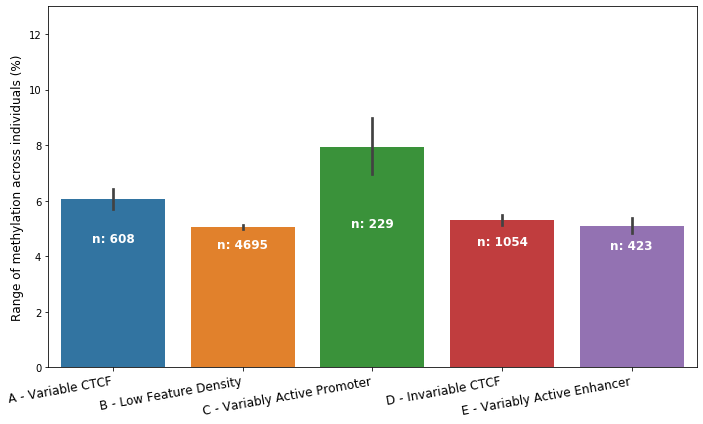

In [97]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(x="cluster_assignments", y="t_range",
                 order=label_order, data=sorted_total_df)

ax.set(xticklabels=["A - Variable CTCF", "B - Low Feature Density",
                    "C - Variably Active Promoter", "D - Invariable CTCF",
                    "E - Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)

medians = sorted_total_df.groupby(['cluster_assignments'])['t_range'].median().values
nobs = sorted_total_df.groupby(['cluster_assignments'])['t_range'].agg(['count'])
nobs = ["n: " + str(i) for s in nobs.values for i in s]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] - 0.3, nobs[tick],
            horizontalalignment='center', size='x-small',
            color='w', weight='semibold',
            fontsize=12)

plt.tight_layout()

ax.set(ylim=(0, 13))

plt.savefig("plots/blueprint_barplot.png", dpi=200)
plt.savefig("plots/blueprint_barplot.pdf")

In [78]:
import scipy.stats as stats
# p-value for 3 comparisons 0.166
stats.ttest_ind(sorted_total_df['t_range'][sorted_total_df['cluster_assignments'] == 'A'],
                sorted_total_df['t_range'][sorted_total_df['cluster_assignments'] == 'C'],
                nan_policy='omit')

Ttest_indResult(statistic=-4.260579489893146, pvalue=2.2710557395122755e-05)

In [ ]:
val_df["t_range"] = methylation_df["T.range2"].copy()
sort_val_df = val_df[val_df["t_range"].notnull()].copy()

In [ ]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

ax = sns.scatterplot(x="pca_x", y="pca_y",
                     size="t_range", data=sort_val_df)
ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
plt.savefig("plots/pca_blueprintdata.png", dpi=200)
plt.savefig("plots/pca_blueprintdata.pdf")

In [ ]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, verbose=False, random_state=1)
reducer.fit(kbest_total_abs)

In [ ]:
embedding_total = reducer.transform(kbest_total_abs)
embedding_val = reducer.transform(kbest_val_abs)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]
hue_order = ["Untested", "Tissue-specific", "True ME","False-positive"]

ax = sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1],
                     hue=total_df["val_result"], hue_order=hue_order, s=20, marker='o')
ax.set(xlim=(-20, 20), ylim=(-20, 20))

In [ ]:
ax = sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["val_result"], hue_order=hue_order)
ax.set(xlim=(-20, 20), ylim=(-20, 20))